# Mô hình Causal Logistic Survival
Bs Vương Kiến Thanh

Ba bài đầu tiên rất quan trọng, qua đó bạn sẽ nắm được:
- Định nghĩa hazard, survival, cách chuyển đổi từ hazard -> survival.
- Fit mô hình survival bằng pp parametric là hồi quy logistic.
- Điều chỉnh trọng số của các mẫu đối tượng nghiên cứu, thông qua IP weighting, nhằm đạt đến suy luận nhân quả

Tất cả những kiến thức trên đều là kiến thức tiên nghiệm để đến bài hôm này, là nội dung chính của Causal survival analysis.

Ở bài 2, chúng ta đã thấy kết quả của mô hình logistic surival cho rằng việc ngưng hút thuốc lá sẽ làm giảm tỉ lệ sống còn so với việc duy trì hút thuốc lá. Nhưng đó là mô hình chưa được điều chỉnh theo các hiệp biến $L$, sẽ gây sai lệch (bias) khi suy luận hiệu ứng của điều trị (ngưng hút thuốc).

Ví dụ: Người giá thì ít hút thuốc hơn và dễ tử vong hơn.

Hôm nay chúng ta sẽ điều chỉnh trọng số của từng mẫu đối tượng nghiên cứu, theo các hiệp biến $L$, từ đó suy ra hiệu ứng nhân quả của điều trị.

Bộ dataset vẫn là NHEFS:
- Điều trị ($A$): `qsmk`: ngưng hút thuốc
- Kết cục ($D$): `time_to_evt`: thời gian đến sự kiện (tử vong)
- Hiệp biến ($L$): [`age`, `wt71`, `smokeintensity`, `smokeyrs`, `education`, `exercise`, `active`, `sex`, `race`]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.optim import Adam
from numpyro.diagnostics import print_summary
import arviz as az
import jax.numpy as jnp
from jax.scipy.special import expit
from jax.random import PRNGKey
from jax import vmap
az.style.use("fivethirtyeight")

def survival_curve_from_model(model, samples, qsmk, scalers):
    def survival_curve(hazard):
        survival = [1 - hazard[0]]
        for i in range(1, len(hazard)):
            survival.append((1 - hazard[i]) * survival[i - 1])
        return jnp.array(survival)
    hazard = Predictive(model, samples, return_sites=['hazard'])(
        PRNGKey(1), qsmk=qsmk,
        time=scalers['time'].transform(np.arange(120).reshape(-1,1)).ravel(),
        cal=True
    )['hazard']
    return vmap(survival_curve)(hazard)

def get_stabilized_IP_weight(df, A, continuous, multi_cate, binary_cate):
    # transform data to quadratic & one hot encoding
    quadratic = [x+'^2' for x in continuous]
    for q,c in zip(quadratic, continuous):
        df[q] = df[c]**2
    std_col = continuous + quadratic
    scalers = dict()
    for col in std_col:
        scalers[col] = StandardScaler()
        df[col+'_std'] = scalers[col].fit_transform(df[[col]])
    continuous_std = [x+'_std' for x in continuous+quadratic]
    dummies = []
    all_cate = binary_cate.copy()
    for c in multi_cate:
        dummies += [pd.get_dummies(df[c], prefix=c)]
        all_cate += [c + '_'+ str(i) for i in df[c].unique()]
    df = pd.concat([df] + dummies, axis=1)
    L = continuous_std + all_cate
    # find f(A|L) and f(A) -> stb ipw
    pr_A_L = LogisticRegression()
    pr_A_L.fit(
        X=df[L],
        y=df[A].values)
    probs = pr_A_L.predict_proba(df[L])
    denom = np.where(df[A]==0, probs[:,0], probs[:,1])
    pr_A_0 = (df[A]==0).sum() / df.shape[0]
    numer = np.where(df[A]==0, pr_A_0, 1-pr_A_0)
    df['IP_weight_stb'] = numer/denom   
    return df, scalers

def person_time_format(DF, scalers):
    DF['time_to_evt']=np.where(DF['death']==1, (DF['yrdth']-83)*12 + DF['modth'], np.nan)
    seqn, qsmk, time, death, weight = [],[],[],[],[]
    def add(row):
        if pd.isna(row['time_to_evt']):
            seqn.extend([int(row['seqn'])]*120)
            qsmk.extend([int(row['qsmk'])] *120)
            time.extend(range(120))
            death.extend([0]*120)
            weight.extend([row['IP_weight_stb']]*120)
        else:
            t = int(row['time_to_evt'])
            seqn.extend([int(row['seqn'])]*t)
            qsmk.extend([int(row['qsmk'])]*t)
            time.extend(range(t))
            death.extend([0]*(t-1) + [1])
            weight.extend([row['IP_weight_stb']]*t)
    DF.apply(add, axis=1)
    scalers['time'] = StandardScaler()
    time_std = scalers['time'].fit_transform(np.array(time).reshape(-1,1)).ravel()
    return (pd.DataFrame({
        'id':seqn,
        'qsmk':qsmk,
        'time':time,
        'time_std':time_std,
        'death':death,
        'IP_weight_stb':weight}),
        scalers)

In [2]:
origin = pd.read_csv(
    r'https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv',)

## Bước 1: Tìm stabilized IP weight

$$SW^A = \frac{f(A)}{f(A|L)} $$

Vì $A$ `qsmk` là biến nhị phân, chúng ta dùng logistic để tìm $f(A|L)$, và đếm tần số để tìm $f(A)$. 

In [3]:
struct = {
    'A': 'qsmk',
    'continuous': ['age', 'wt71','smokeintensity','smokeyrs'],
    'multi_cate': ['education', 'exercise', 'active'],
    'binary_cate': ['sex', 'race'],
}
df, scalers = get_stabilized_IP_weight(origin, **struct)
df['IP_weight_stb'].describe()

count    1629.000000
mean        0.996980
std         0.268887
min         0.329762
25%         0.868226
50%         0.950228
75%         1.077568
max         3.973439
Name: IP_weight_stb, dtype: float64

## Bước 2: Chuyển định dạng Person-time
Person-time format là định dạng thường gặp trong phân tích survival.

Dòng đầu tiên là thông tin của người 1 tại $k=0$, dòng thứ hai là thông tin của người 1 tại $k=1$, và tiếp tục đến cuối kỳ theo dõi của người đó. Tiếp theo đến người 2 và cứ thế thêm vào.


In [4]:
df2, scalers = person_time_format(df, scalers)
df2

,id,qsmk,time,time_std,death,IP_weight_stb
0,233,0,0,-1.653591,0,0.833522
1,233,0,1,-1.624671,0,0.833522
2,233,0,2,-1.595751,0,0.833522
3,233,0,3,-1.566831,0,0.833522
4,233,0,4,-1.537911,0,0.833522
...,...,...,...,...,...,...
176759,25061,1,115,1.672209,0,1.407753
176760,25061,1,116,1.701129,0,1.407753
176761,25061,1,117,1.730049,0,1.407753
176762,25061,1,118,1.758969,0,1.407753


## Bước 3: Fit mô hình logistic có trọng số
$$\text{logit hazard} = \theta_0 + \theta_1 k + \theta_2 k^2 + \theta_{3[qsmk]} + \theta_{4[qsmk]} k + \theta_{5[qsmk]} k^2$$

Từ hazard chuyển thành survival:
$$ \text{survival}_k = \Pi_{m=1}^k 1-\text{hazard}_m$$

Bộ data này rất lớn, việc dùng `SVI` sẽ cải thiện tốc độ infer tham số rất nhiều, nhưng bù lại sẽ cho phân phối tham số không chính xác bằng MCMC.

In [5]:
def model(qsmk, time, IP_weight=1, death=None, cal=False):
    theta0 = npr.sample('theta0', dist.Normal(0,1))
    theta1 = npr.sample('theta1', dist.Normal(0,1))
    theta2 = npr.sample('theta2', dist.Normal(0,1))
    theta3 = npr.sample('theta3', dist.Normal(0,1).expand([2]))
    theta4 = npr.sample('theta4', dist.Normal(0,1).expand([2]))
    theta5 = npr.sample('theta5', dist.Normal(0,1).expand([2]))
    logit = theta0 + theta1 * time + theta2 * (time**2) +\
        theta3[qsmk] + theta4[qsmk] * time + theta5[qsmk] * (time**2)
    if cal:
        hazard = npr.deterministic('hazard', expit(logit))
    else:
        npr.factor('death', IP_weight*dist.Binomial(logits=logit).log_prob(death))
    
def svi_run(model, data):
    guide = AutoLaplaceApproximation(model)
    svi = SVI(model, guide, Adam(1), Trace_ELBO(), **data)
    params = svi.run(PRNGKey(1), 2000).params
    samples = guide.sample_posterior(PRNGKey(2), params, (2000,))
    print_summary(samples, 0.95, False)
    return samples

In [6]:
# causal
data = {
    'qsmk': df2.qsmk.values,
    'time': df2.time_std.values,
    'death': df2.death.values,
    'IP_weight': df2.IP_weight_stb.values
}
samples = svi_run(model, data)
survival0 = survival_curve_from_model(model, samples, 0, scalers)
survival1 = survival_curve_from_model(model, samples, 1, scalers)

100%|██████████| 2000/2000 [00:17<00:00, 113.65it/s, init loss: 438429.5938, avg. loss [1901-2000]: 2307.6160]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
    theta0     -3.42      0.58     -3.43     -4.56     -2.36   1933.34      1.00
    theta1      0.07      0.58      0.07     -1.04      1.22   1814.29      1.00
    theta2     -0.61      0.57     -0.60     -1.78      0.45   2055.59      1.00
 theta3[0]     -2.76      0.58     -2.76     -3.91     -1.68   1850.47      1.00
 theta3[1]     -2.52      0.58     -2.51     -3.69     -1.46   2043.34      1.00
 theta4[0]      0.12      0.58      0.13     -1.01      1.25   1819.59      1.00
 theta4[1]     -0.07      0.58     -0.07     -1.26      1.01   1858.55      1.00
 theta5[0]      0.46      0.57      0.47     -0.65      1.56   2071.29      1.00
 theta5[1]      0.19      0.57      0.19     -1.04      1.23   2003.62      1.00



In [7]:
# biased
data = {
    'qsmk': df2.qsmk.values,
    'time': df2.time_std.values,
    'death': df2.death.values,
}
samplesb = svi_run(model, data)
survival0b = survival_curve_from_model(model, samplesb, 0, scalers)
survival1b = survival_curve_from_model(model, samplesb, 1, scalers)

100%|██████████| 2000/2000 [00:17<00:00, 117.23it/s, init loss: 437685.5625, avg. loss [1901-2000]: 2313.6035]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
    theta0     -3.40      0.58     -3.41     -4.54     -2.34   1933.34      1.00
    theta1      0.06      0.58      0.06     -1.06      1.20   1814.29      1.00
    theta2     -0.59      0.57     -0.59     -1.76      0.47   2055.70      1.00
 theta3[0]     -2.87      0.58     -2.86     -4.00     -1.78   1848.57      1.00
 theta3[1]     -2.35      0.58     -2.34     -3.51     -1.29   2040.82      1.00
 theta4[0]      0.13      0.58      0.14     -1.00      1.26   1819.82      1.00
 theta4[1]     -0.09      0.58     -0.10     -1.29      0.98   1851.81      1.00
 theta5[0]      0.43      0.57      0.44     -0.69      1.52   2072.25      1.00
 theta5[1]      0.23      0.57      0.23     -0.96      1.29   2008.13      1.00



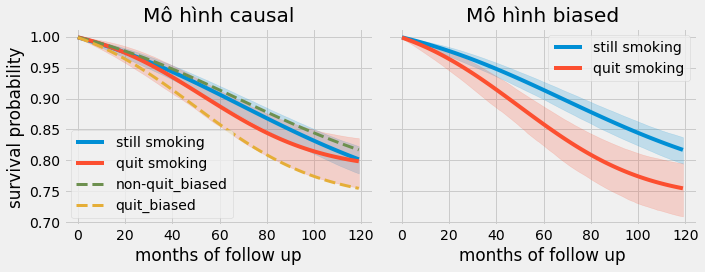

In [8]:
fig, axes = plt.subplots(1,2, sharey=True,figsize=(10,4))
for ax, s0, s1, t in zip(
        axes,
        [survival0, survival0b],
        [survival1, survival1b],
        ['Mô hình causal', 'Mô hình biased']):
    ax.plot(range(120), s0.mean(0), label='still smoking')
    ax.plot(range(120), s1.mean(0), label='quit smoking')
    ax.fill_between(
        range(120),
        *jnp.quantile(s0, q=jnp.array([0.025,0.975]),axis=0),
        color='C0', alpha=0.2)
    ax.fill_between(
        range(120),
        *jnp.quantile(s1, q=jnp.array([0.025,0.975]),axis=0),
        color='C1', alpha=0.2)
    ax.legend()
    ax.set_title(t)
    
    ax.set_xlabel('months of follow up')
    
axes[0].plot(range(120), survival0b.mean(0), ls='dashed', c='C3',lw=3, label='non-quit_biased')
axes[0].plot(range(120), survival1b.mean(0), ls='dashed', c='C2',lw=3, label='quit_biased')
axes[0].set_ylabel('survival probability')
axes[0].legend()
plt.tight_layout()

Trong ví dụ này, tỉ lệ sống còn 120 tháng được ước lượng ở nhóm ngưng hút thuốc là 80.7% và nhóm không ngưng hút thuốc là 80.5%. Sự khác nhau 0.2% (KTC 95% -4.1% đến 3.7%). Mặc dù đường cong sống còn ở nhóm ngưng thuốc lá thấp hơn so với nhóm tiếp tục hút thuốc lá trong hầu hết khoảng thời gian theo dõi, khác biệt lớn nhất không bao giờ vượt qua -1.4% với khoảng tin cậy 95% từ -3.4% đến 0.7%. 

Nghĩa là, sau khi điều chỉnh bởi các hiệp biến $L$ qua  IP weighting, có rất ít bằng chứng về hiệu ứng của ngưng hút thuốc lên tỉ lệ tử vong tại bất kỳ thời điểm nào trong thời gian theo dõi.